In [80]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u 
import astropy.units.imperial as ui 
import os 
from pyXSteam.XSteam import XSteam
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator, FormatStrFormatter
from math import pi

ui.enable()
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

if not os.path.exists('figs'): 
    os.mkdir('figs')

from helper import print_value

Reactor Params

In [81]:
from helper import calc_Ax, calc_De
Qdot = 3976 * u.MW
gamma_f = 0.974
P = 1040 * ui.psi
T_in = 410 * ui.deg_F
F_q = 3.15 
F_z = 1.45 
H = (176 * ui.inch).to(ui.ft)
D = (0.4039 * ui.inch).to(ui.ft)
D_i = (0.3441 * ui.inch).to(ui.ft)
D_f = (0.3386 * ui.inch).to(ui.ft)
S = (0.5098 * ui.inch).to(ui.ft)
k_c = 9.6 * ui.BTU / (u.h * ui.ft * ui.deg_F)
H_g = 1200 * ui.BTU / (u.h * ui.ft**2 * ui.deg_F)
n_a = 872 
n_fr_a = 92 
n_w = 8 
n_sg = 8 
K_sg = 0.6 
K_in = 1.5 
K_out = 1.0 
K_dc = 2.5
V_d = (280 * ui.inch).to(ui.ft)
C_d = (184 * ui.inch).to(ui.ft)
C_h = 12 * ui.ft 
Ax = calc_Ax(S, D)
De = calc_De(Ax, D)

Extrapolated Distance

i = 2028757
i = 2028758
Omega = 2.02876


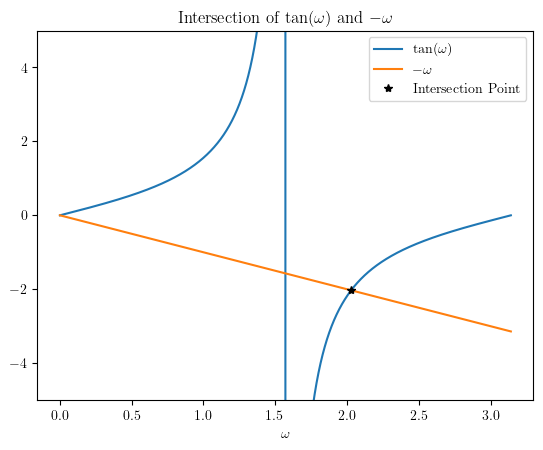

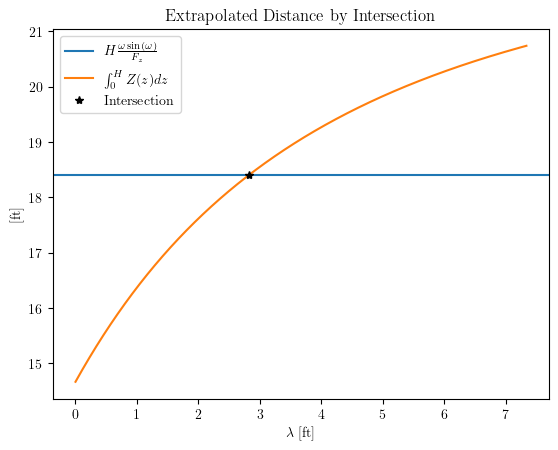

lambda = 2.822000E+00 ft


In [82]:
from helper import find_lambda

lambda_, omega = find_lambda(D, H, F_z)

Pressure Drop and Mass Flux in Average Channel 

80224
qpp_bar_0 = 8.462903E+04 BTU / (ft2 h)


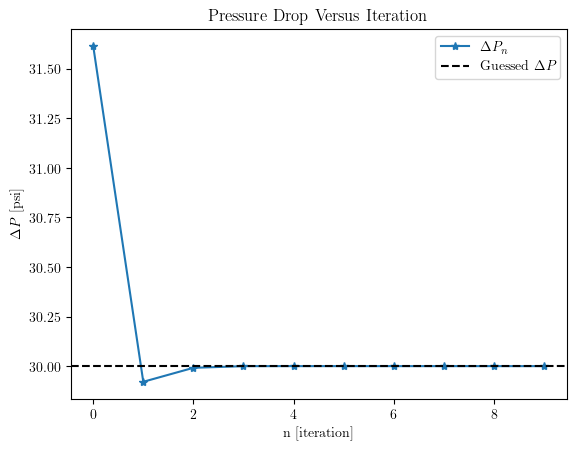

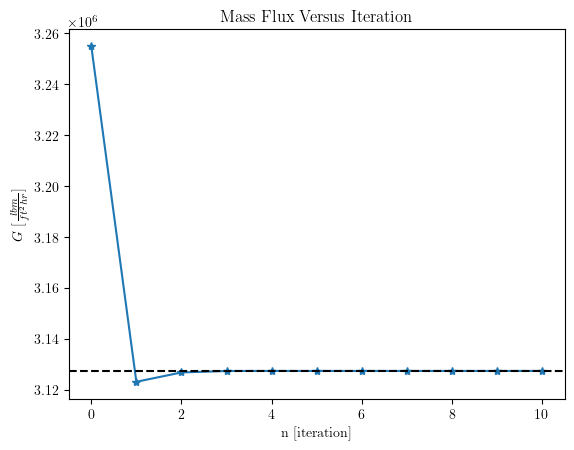

In [83]:
from helper import calc_qpp_bar, find_G_deltaP, calc_G, calc_Re, friction_factor, calc_deltaP, calc_G, enthalpy_profile, calc_h_bar
from helper import int_shape
n = n_a * n_fr_a
print(n)

qpp_bar_0 = calc_qpp_bar(gamma_f, n, D, Qdot, H, lambda_)
print_value('qpp_bar_0', qpp_bar_0)

epsilon = 1e-10
deltaP_avg = 30 * ui.psi

def find_G_fbar(deltaP, fbar, qpp_0, epsilon, P, T_in, H, D, De, Ax, n_sg, K_sg, K_dc, K_in, K_out, lambda_, gamma_f, show=False, channel=''):
    steamTable = XSteam(XSteam.UNIT_SYSTEM_FLS)
    deltaP_curr = 0 * ui.psi
    rho = steamTable.rho_pt(P.value, T_in.value) * ui.lbm / ui.ft**3
    h_0 = steamTable.h_pt(P.value, T_in.value) * ui.BTU / ui.lbm
    rho_bar = rho 
    rho_in = rho 
    rho_out = rho 
    mu_bar = steamTable.my_pt(P.value, T_in.value) * ui.lbm / (ui.ft * u.hr)

    G_curr = calc_G(deltaP, H, n_sg, K_sg, K_dc, K_in, K_out, fbar, De, rho_bar, rho_in, rho_out)
    G_prev = 0 * ui.lbm / (ui.ft**2 * u.h)
    Re = calc_Re(G_curr, D, mu_bar)
    fbar = friction_factor(Re)
    G_vals = np.zeros(0) * ui.lbm / (ui.ft**2 * u.h)
    deltaP_vals = np.zeros(0) * ui.psi
    G_vals = np.append(G_vals, G_curr)
    while np.abs(deltaP.value - deltaP_curr.value) >= epsilon: 
        
        mdot = G_curr * Ax
        deltaP_curr = calc_deltaP(G_curr, H, n_sg, K_sg, K_dc, K_in, K_out, fbar, De, rho_bar, rho_in, rho_out)
        
        h_out = enthalpy_profile(H, qpp_0, H, D, mdot, lambda_, h_0, gamma_f)
        h_bar = calc_h_bar(h_0, D, gamma_f, mdot, qpp_0, H, lambda_)

        rho_bar = steamTable.rho_ph(P.value, h_bar.value) * ui.lbm / ui.ft**3
        rho_out = steamTable.rho_ph(P.value, h_out.value) * ui.lbm / ui.ft**3
        mu_bar = steamTable.my_ph(P.value, h_bar.value) * ui.lbm / (ui.ft * u.hr)

        G_prev = G_curr 
        G_curr = calc_G(deltaP, H, n_sg, K_sg, K_dc, K_in, K_out, fbar, De, rho_bar, rho_in, rho_out)

        Re = calc_Re(G_curr, D, mu_bar)
        fbar = friction_factor(Re)
        G_vals = np.append(G_vals, G_curr)
        deltaP_vals = np.append(deltaP_vals, deltaP_curr)
    if show: 
        plt.figure() 
        plt.plot(deltaP_vals, '-*')
        plt.axhline(deltaP.value, c='k', linestyle='--')
        plt.legend(['$\Delta P_n$', 'Guessed $\Delta P$'])
        plt.title('Pressure Drop Versus Iteration')
        plt.xlabel('n [iteration]')
        plt.ylabel('$\Delta P$ [psi] ')
        plt.savefig('figs/deltaP_' + channel + '.pdf', format='pdf', bbox_inches='tight')
        plt.show() 

        plt.figure() 
        plt.plot(G_vals, '-*')
        plt.axhline(G_vals[-1].value, c='k', linestyle='--')
        plt.title('Mass Flux Versus Iteration')
        plt.xlabel('n [iteration]')
        plt.ylabel('$G$ $[\\frac{lbm}{ft^2 hr}]$ ')
        plt.savefig('figs/G_' + channel + '.pdf', format='pdf', bbox_inches='tight')
        plt.show() 
    
    return G_curr, fbar

    

G_avg, fbar_avg = find_G_fbar(deltaP_avg, 1.2E-02, qpp_bar_0, epsilon, P, T_in, H, D, De, Ax, n_sg, K_sg, K_dc, K_in, K_out, lambda_, gamma_f, True, 'avg')


Pressure Drop and Mass flux in hot channel

106207.25140311541 BTU / (ft2 h)
183849.96780181234 BTU / (ft2 h)


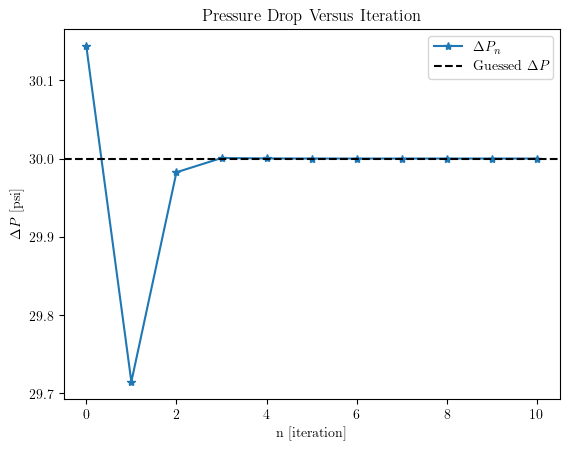

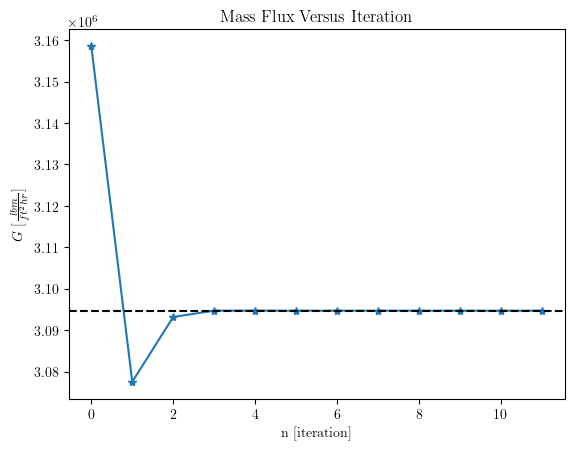

In [84]:
qpp_bar = qpp_bar_0 * int_shape(0, H, H, lambda_) / H 
print(qpp_bar)

qpp_0_max = F_q * qpp_bar / (omega * np.sin(omega))
print(qpp_0_max)

G_hot, fbar_hot = find_G_fbar(deltaP_avg, fbar_avg, qpp_0_max, epsilon, P, T_in, H, D, De, Ax, n_sg, K_sg, K_dc, K_in, K_out, lambda_, gamma_f, True, 'hot')
